# ML-5 Валидация данный и оценка моделей
###  Содержание <a class="anchor" id=0></a>
- [1. Введение](#1)
- [2. Валидация данных. Методы валидации](#2)
- [2.1 hold-out (отложенная выборка)](#2-1)
- [2.2 k-fold (кросс валидация)](#2-2)
- [2.3 leave-one-out (отложенный пример)](#2-3)
- [3. Дисбаланс выборки](#3)
- [4. Недообучение и переобучение. Утечка данных](#4)
- [5. Кривая обучения](#5)
- [6. Практика](#6)
- [7. Итоги](#7)


2. # Валидация данных. Методы валидации <a class="anchor" id=2></a>

[к содержанию](#0)

**Главная цель машинного обучения** — усвоить общие закономерности в данных, а не просто запомнить обучающий, или тренировочный, набор данных (training data).

Поэтому так важно иметь отложенный набор данных (с известными правильными ответами), который модель не видела во время обучения. На нём мы будем оценивать качество обученной модели.

>В предыдущих модулях по машинному обучению тот набор данных, на котором мы проверяли качество построенной модели, мы называли тестовым набором данных (`testing data`). Мы заранее выделяли этот набор данных для того, чтобы рассчитать финальную метрику модели и сделать вывод о том, устраивает ли нас качество моделирования. Такой подход называется `двухкомпонентным`.

<img src=ml5_img1.png width=400>

>**Примечание**. Ранее мы использовали тестовый набор не только для проверки итогового качества, но и для подбора внешних параметров. Вспомните: мы выбирали оптимальные пороги вероятности и коэффициенты регуляризации, при которых наблюдался максимум целевой метрики (мы использовали `F1`-меру). 
>
>Однако такой подход не совсем корректен, ведь мы подстраивали модель под тестовую выборку, то есть по сути занимались небольшим самообманом. Тестовая выборка должна быть «независимым судьёй», который должен объективно и непредвзято «выносить приговор» нашей модели.

Из-за этого в больших Data Science-проектах используется не два, а три набора данных: в дополнение к тренировочному и тестовому набору данных выделяется **валидационный набор** (`validation data`). Этот набор используется для промежуточного контроля качества модели и настройки внешних параметров, которые задаёт исследователь при построении модели. Такой подход называется трёхкомпонентным.

<img src=ml5_img2.jpg width=400>

## Итак, существует три основных вида выборок, которые используются в машинном обучении:

1. **Обучающая (тренировочная)** — набор данных, который используется в процессе обучения модели (подбора внутренних параметров, например коэффициентов линейной регрессии или предикатов в деревьях решений).

2. **Валидационная (проверочная)** — набор данных, на котором мы оцениваем промежуточные результаты обучения.

Основная цель создания такого набора данных — отслеживание переобучения.

На валидационной выборке мы производим подбор гиперпараметров — внешних параметров модели, например коэффициентов регуляризации, максимальной глубины дерева, количества деревьев в случайном лесу и т. д.

3. **Тестовая (контрольная)** — набор данных, который имитирует работу модели в реальных условиях после подбора всех параметров.

С помощью этого набора осуществляется окончательная проверка качества.

Главное условие для тестовой выборки — она должна быть независимой от обучающей.

> ## ОСОБЕННОСТИ ТЕРМИНОЛОГИИ
>
>В промышленности, научных кругах и различной литературе термины **валидационная** и **тестовая выборка** зачастую употребляются как синонимы. Строго говоря, они не являются таковыми.
>
>**Тестирование** — это попытка что-то выяснить, а **валидация** — доказать, что что-то является истиной (в нашем случае — доказать, что качество модели на валидационной выборке совпадает с качеством при обучении).
>
>Вне зависимости от того, как будут называться контрольные выборки, важная концепция, которую необходимо сохранить, состоит в том, что окончательный набор (называемый тестом или валидацией) не используется в процессе обучения модели, а используется исключительно для оценки её качества.

Процесс проверки предсказательной способности модели машинного обучения называется `валидацией`.

Существует несколько методов такого контроля. Мы последовательно рассмотрим каждый из них.

Но прежде чем мы перейдём к обсуждению методов валидации, давайте познакомимся с данными, на которых будем практиковаться

В этом модуле мы будем решать задачу классификации: классифицировать воду на пригодную  и не пригодную для питья на основе её химического состава.

Скачать набор данных можно [здесь](https://lms.skillfactory.ru/assets/courseware/v1/9cd645af21ef409ff23bf03a783b4b71/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/water_potability.zip). С подробным описанием датасета и столбцов таблицы ознакомьтесь [в источнике](https://www.kaggle.com/datasets/adityakadiwal/water-potability).

Переходим к работе с данными. Импортируем модули, которые нам понадобятся:

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn') #стиль отрисовки seaborn
%matplotlib inline

In [3]:
water_data = pd.read_csv('water_potability.zip')
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


Невооруженным глазом видно, что большинство столбцов таблицы являются числовыми. Целевой признак — `Potability` (пригодность для питья): `1` — вода пригодна, `0` — вода не пригодна.

В данных есть пропуски. Выведем информацию о них в процентном соотношении:

In [4]:
display(water_data.isnull().mean() * 100)

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

Итак, у нас отсутствует около `15 %` информации о кислотности воды (`ph`), около` 24 %` — о содержании сульфатов (`Sulfate`) и около `5 %` — о тригалометанах (`Trihalomethanes`). Мы знаем, что пропуски — непосильная ноша для большинства моделей машинного обучения. Их необходимо обработать.

Заполним пропуски медианным значением в признаке зависимости класса воды (`Potability`). Для этого сгруппируем данные по признаку `Potability`, посчитаем медиану в каждой группе, а затем отправим результат в метод `fillna()`:

In [5]:
#Заполняем пропуски
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

display(water_data.isnull().mean() * 100)

ph                 0.0
Hardness           0.0
Solids             0.0
Chloramines        0.0
Sulfate            0.0
Conductivity       0.0
Organic_carbon     0.0
Trihalomethanes    0.0
Turbidity          0.0
Potability         0.0
dtype: float64

Теперь проблема пропусков устранена. Давайте по традиции разделим набор данных на матрицу наблюдений `X` и вектор правильных ответов `y`:

In [5]:
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

# HOLD-OUT <a class="anchor" id=2-1></a>

[к содержанию](#0)

Метод `hold-out` (отложенная выборка) нам уже знаком. Это самый простой и очень популярный метод.

Его идея состоит в том, что для проверки модели мы просто случайным образом разбиваем весь набор данных на обучающую, валидационную и тестовую выборки (последняя — по желанию).

Обычно разбиение производится в соотношении `70/30` или `80/20` при двухкомпонентном подходе, и в соотношении `70/15/15` или `80/10/10` — при трёхкомпонентном.

Схема разбиения представлена ниже:

<img src=ml5_img3.png>

## Плюсы:

* Очень простой и понятный.

* Чаще всего применяется на больших датасетов, так как требует значительно меньше вычислительных мощностей, чем другие методы.

## Минусы:

* Важно помнить, что разбиение производится случайным образом и оценка в этом методе зависит от того, какие наблюдения попали в набор для валидации. Это плохо, так как возможна ситуация, когда распределение целевого признака в тренировочной, валидационной (и тестовой) выборках может значительно различаться и оценка качества может быть необъективной.

## РЕАЛИЗАЦИЯ МЕТОДА В `SKLEARN`

Все методы разбиения выборки и валидации, которые мы будем изучать, находятся в модуле `model_selection`, мы импортировали его заранее.

Метод hold-out реализован в уже знакомой вам функции [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Она предназначена для разбиения исходного набора данных случайным образом на две части в заданных соотношениях.

>Основные параметры `train_test_split()`:
>
>* `*arrays` — порядковый аргумент с переменным количеством. Набор массивов (это могут быть списки, numpy-массивы, DataFrame), которые подлежат разбиению.
>* `test_size` — размер тестовой (валидационной) выборки. Может быть указан в долях. Определяется автоматически, если параметр `test_size` передан как `1-train_size`.
>* `train_size` — размер тренировочной выборки. Может быть указан в долях. Определяется автоматически, если параметр `test_size` передан как `1-test_size`.
>* `random_state` — число, на основе которого производится генерация случайных чисел.
>* `shuffle` — параметр, указывающий, стоит ли перемешивать выборку перед разбиением (по умолчанию `True`).
>* `stratify` — стратифицированное разбиение (о нём мы поговорим в юните по дисбалансу выборки).

Если мы используем двухкомпонентный подход (разбиваем выборку на тренировочную и валидационную, она же тестовая), то всё очень просто: нам лишь нужно вызвать функцию `train_test_split()` и передать в неё матрицу наблюдений `X` и вектор-столбец с правильными ответами `y`.

Для примера разделим выборку в соотношении `80/20` (`test_size=0.2`), в качестве значения параметра `random_state` по традиции возьмём число `42`.

Функция вернёт четыре массива:

* таблицу `X` с обучающими примерами,
* таблицу `X` с примерами для валидации,
* столбец `y` с ответами на обучающие примеры,
* столбец `y` с ответами на валидационные примеры.

In [6]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (2620, 9)
Valid shape: (656, 9)


Итак, `2 620` образцов воды являются обучающими — в них модель будет искать закономерности и подбирать внутренние параметры, а `656` являются валидационными — на них мы будем производить контроль качества.

Далее нам останется только обучить модель на тренировочной выборке (`X_train`, `y_train`) и рассчитать метрики на валидационной выборке (`X_valid`, `y_valid`).

В качестве модели будем использовать дерево решений с максимальной глубиной `7`, `энтропией` в качестве критерия информативности, минимальное число объектов в листе дерева — `5`.

После обучения сделаем предсказание для каждой из выборок и рассчитаем метрику. В качестве метрики для простоты возьмём долю правильных ответов — `accuracy`.

In [7]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print('Train hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Valid hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred))) 

Train hold-out accuracy: 0.82
Valid hold-out accuracy: 0.77


Если же мы используем `трёхкомпонентный` подход (разбиваем выборку на тренировочную, валидационную и отдельную тестовую), тут нам понадобится чуть больше кода. К сожалению, в `sklearn` нет специализированного функционала для такого разбиения.

Применим функцию `train_test_split()` дважды: сначала разобьём исходный набор на тренировочный и валидационный в соотношении `80/20`, затем разобьём валидационный набор на валидационный и тестовый в соотношении `50/50`. В итоге наша выборка будет разбита в соотношении `80/10/10`:

In [8]:
#разбиваем исходную выборку на тренировочную и валидационную в соотношении 80/20
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
#разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

# K-FOLD <a class="anchor" id=2-2></a>

[к содержанию](#0)

>Метод `k-fold` более известен как `кросс-валидация` (`cross validation`), или перекрёстный контроль.

Пожалуй, это самый **популярный метод валидации** для оценки качества моделирования, и он используется практически во всех проектах. Эта идея также применяется во многих моделях и методах машинного обучения, например в стекинге.

Напомним алгоритм кросс-валидации:

1. Разбить исходную выборку на `k` частей — **фолдов (fold)**.

2. Повторять `k` раз:
* Обучить модель на `k-1` частях. Назовём их тренировочными фолдами (`training fold`). 
* Произвести оценку качества (вычислить метрику) на оставшейся части. Назовем её валидационным фолдом (`validation fold`).

3. Усреднить значения метрики на валидационных фолдах.


Схематично алгоритм кросс-валидации можно представить следующим образом (на рисунке представлена схема работы кросс-валидации с предварительно выделенной для тестирования выборкой):

<img src=ml5_img4.png>

Благодаря такому подходу мы избавляемся от необходимости создавать отложенную валидационную выборку — мы генерируем её искусственно на каждом из этапов кросс-валидации из исходного набора данных. Каждая из `k` частей исходного обучающего набора данных используется в качестве валидационной выборки.

Для больших наборов данных в качестве значения `k` часто берут `10`, то есть выборка разбивается на десять фолдов. В случае маленьких выборок `k` берут равным `3 или 5`.

>Чем больше `k`, тем больше моделей будут обучаться, тем объективнее будет оценка качества, однако тем больше времени займёт процесс валидации.

## Плюсы:

* Подход позволяет получить более устойчивую к выбросам оценку качества модели, так как модель обучается на нескольких независимых наборах данных.

* Значения метрик получаются более объективными, ведь мы обучаем одну модель `k` раз — у нас получается `k` независимых друг от друга значений метрики.

>**Примечание**. Мы оцениваем метрику не по одному значению на валидационной выборке, как это было в `hold-out`, а по `k` значений. Если `k` достаточно велико, можно даже построить гистограмму и оценить, в каких пределах находится истинное качество. Однако на практике этим занимаются крайне редко, так как такие вычисления очень времязатратны.

## Минусы:

* Подход предусматривает, что мы обучаем одну и ту же модель `k` раз, что, очевидно, плохо сказывается на производительности. Если модель обучается довольно медленно (например, сложная нейронная сеть), то валидация может занять очень много времени.

# РЕАЛИЗАЦИЯ МЕТОДА В SKLEARN

В библиотеке `sklearn` метод `k-fold` реализован в классе `KFold`.

>Основные параметры инициализатора `KFold`:
>
>* `n_split` —  число фолдов (число  из метода `k-fold`). По умолчанию — `5`.
>* `shuffle` — параметр, указывающий, стоит ли перемешивать исходный набор данных перед разбиением. По умолчанию — `False`.
>* `random_state` — число, на основе которого производится генерация случайных чисел, если набор данных будет перемешиваться.

У объекта класса `KFold` есть метод `split()`. В данный метод необходимо передать матрицу наблюдений `X` и вектор-столбец ответов `y` — метод вернёт генератор, который позволит получать индексы тренировочной и валидационной выборок, сгенерированных по методу `k-fold`.

Будем использовать двухкомпонентный контроль, то есть подавать в кросс-валидацию весь доступный набор данных без предварительного выделения тестовой выборки.

Создадим объект `KFold` для кросс-валидации с пятью фолдами, остальные параметры оставим по умолчанию. Затем организуем цикл `for` для получения элементов из генератора, созданного с помощью метода `split()`. На каждой итерации в переменных `train_index` и `valid_index` будут находиться индексы текущей тренировочной и валидационной выборок соответственно.

>**В цикле будем:**
>
>* выделять строки таблицы, относящиеся к текущим тренировочной и валидационной выборкам, в отдельные таблицы;
>* обучать дерево решений;
>* делать предсказания для текущих тренировочной и валидационной выборок;
>* рассчитывать метрику accuracy на текущих выборках и заносить её значение в список.

Код будет выглядеть следующим образом:

In [9]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
#Создаём список для хранения тренировочных и валидационных метрик
train_metrics = []
val_metrics = []
#Организуем цикл для кросс-валидации (используем весь набор данных)
#train_index — индексы тренировочной выборки
#valid_index — индексы валидационной выборки
for train_index, valid_index in kf.split(X, y): 
    #Создаём тренировочную и валидационную выборку, обращаясь по текущим индексам
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    #Обучаем случайный лес на тренировочной выборке
    model.fit(X_train, y_train)
    #Делаем предсказание для каждой из выборок
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    #Рассчитываем метрику и заносим её в список
    train_metrics.append(metrics.accuracy_score(y_train, y_train_pred))
    val_metrics.append(metrics.accuracy_score(y_valid, y_valid_pred))

In [10]:
print('train_metrics:', train_metrics)
print('val_metrics: ', val_metrics)

train_metrics: [0.8034351145038168, 0.8168637924456315, 0.8027470431133156, 0.8267836703548264, 0.8157191911484166]
val_metrics:  [0.7957317073170732, 0.7053435114503817, 0.7358778625954199, 0.7282442748091603, 0.732824427480916]


В каждом из выведенных списков содержится по пять значений метрики `accuracy`, вычисленных на тренировочном и валидационном фолдах кросс-валидации. Для агрегированной оценки рассчитаем среднее значение метрик:

In [11]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(train_metrics)))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(val_metrics)))

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


Итак, среднее значение метрики `accuracy` на кросс-валидации равно `0.81` для тренировочных фолдов и `0.74` — для валидационных фолдов. Помним о том, что основной показатель для нас — метрика на **валидационных фолдах** (если не предусмотрена тестовая выборка). 

Согласитесь, сложновато — не совсем в стиле `sklearn`. Тут и циклы, и генераторы... Неужели каждый раз придётся писать подобный код для проведения кросс-валидации?

Конечно же, нет. На самом весь приведённый выше код можно значительно сократить, если использовать специальную функцию для кросс-валидации — [cross_validate()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) из модуля `model_selection`. Она организует процедуру кросс-валидации и расчёт метрик.

>Основные параметры функции `cross_validate()`:
>
>* `estimator` — модель, качество которой будет проверяться на кросс-валидации.
>* `X` — матрица наблюдений.
>* `y` — вектор-столбец правильных ответов.
>* `cv` — кросс-валидатор из библиотеки `sklearn` (например, `KFold`) или количество фолдов, на которые необходимо разбить выборку. По умолчанию используется кросс-валидация на пяти фолдах.
>* `scoring` — название метрики в виде строки либо функция для её вычисления ('`accuracy`', '`precision`', '`recall`', '`f1`' и другие; полный список — в документации к функции).
>* `return_train_score` — параметр, указывающий стоит ли возвращать значения метрики, полученных на тренировочных фолдах. По умолчанию — `False`, то есть метрики считаются только на валидационных фолдах.

Функция возвращает словарь со следующими ключами:

* `fit_time` — время обучения модели на каждой итерации кросс-валидации;
* `score_time` — время вычисления метрик на каждой итерации кросс-валидации;
* `test_score` — значения метрик на валидационных фолдах;
* `train_score` — значения метрик на тренировочных фолдах.

Итоговый код с использованием функции `cross_validate()` будет выглядеть следующим образом:

In [12]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.01994634, 0.02094579, 0.01895118, 0.01894712, 0.01894832]),
 'score_time': array([0.00099754, 0.00102639, 0.00099945, 0.00099635, 0.00199533]),
 'test_score': array([0.79573171, 0.70534351, 0.73587786, 0.72824427, 0.73282443]),
 'train_score': array([0.80343511, 0.81686379, 0.80274704, 0.82678367, 0.81571919])}

В массивах, хранящихся по ключам `train_score` и `test_score`, содержится по пять значений метрики accuracy, полученных на тренировочных и валидационных фолдах соответственно на каждой итерации кросс-валидации. Давайте рассчитаем среднее и сравним его с результатом, полученным ранее:

In [13]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


# LEAVE-ONE-OUT <a class="anchor" id=2-3></a>

[к содержанию](#0)

>Метод `leave-one-out` (отложенный пример), или поэлементная кросс-валидация — это частный случай кросс-валидации (`k-fold`), когда размер `k` равняется размеру всей выборки `k = n`, где `n` — количество примеров (строк в таблице).

Алгоритм метода:

1. Повторять  `n` раз:
 * Выбрать один случайный пример для валидации.
 * Обучить модель на всех оставшихся `n-1` примерах.
 * Произвести оценку качества (вычислить метрику) на отложенном примере.

2. Усреднить значение метрик на всех примерах.

<img src=ml5_img5.png>

## Плюсы:

* Идеально подходит для небольших датасетов (**менее 100 примеров**).

* Поскольку все доступные данные используются как для обучения, так и для валидации, значения метрик наиболее объективны и надёжны.

## Минусы:

* Подход предусматривает, что мы обучаем одну и ту же модель `n` раз. Очевидно, что чем больше примеров в обучающем наборе данных, тем больше моделей мы будем обучать. Поэтому метод не подходит для оценки качества модели на больших наборах данных, поскольку становится **очень ресурсозатратным**.
>**Примечание**. Тем не менее, в некоторых методах обучения вычисление leave-one-out получается заметно ускорить, и его использование становится возможным.

# РЕАЛИЗАЦИЯ МЕТОДА В `SKLEARN`

В библиотеке `sklearn` метод `leave-one-out` реализован в классе `LeaveOneOut`. Параметров инициализации у данного класса нет.

Работа с кросс-валидатором полностью идентична работе с `KFold`, который мы рассматривали ранее (цикл для организации кросс-валидации вручную будет выглядеть аналогично).

Объект класса `LeaveOneOut` также можно передать в функцию `cross_validate()` для получения метрик на каждом из примеров. В случае с метрикой `accuracy` список будет состоять из 0 и 1 (0 — модель не угадала класс на отложенном примере, 1 — модель угадала класс на отложенном примере).

Так как датасет у нас довольно большой (более трёх тысяч образцов воды), алгоритм кросс-валидации `leave-one-out` будет выполняться очень долго. Для экономии времени выполнения кода будем использовать первые `500` наблюдений из исходной таблицы.

>**Примечание**. Значение метрики будет рассчитано не для всего набора данных, а только для его части. Если вы захотите рассчитать метрику на всём наборе данных, вместо среза передавайте в функцию таблицу `X` и столбец `y` целиком. Но имейте в виду, что код в таком случае может выполняться до нескольких минут.

Итоговый код:

In [14]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём кросс-валидатор LeaveOneOut
loo = model_selection.LeaveOneOut()
 
#Считаем метрики на кросс-валидации leave-one-out
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X.iloc[:500], #матрица наблюдений X
    y=y.iloc[:500], #вектор ответов y
    cv=loo, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.95
Valid k-fold mean accuracy: 0.90


>**Примечание**. Метод `leave-one-out` можно реализовать и без использования специального класса — достаточно просто указать параметр `n_split=n` в инициализаторе `KFold`, где `n` — количество строк в таблице.

<img src=ml5_img6.png>

3. # Дисбаланс выборки <a class="anchor" id=3></a>

[к содержанию](#0)

Несбалансированный набор данных (`unbalanced dataset`) — это выборка, в которой количества примеров каждого из классов значительно отличаются.

При этом:

* класс большинства называется мажоритарным (`majority`) классом;

* класс меньшинства называется миноритарным (`minority`) классом.

<img src=ml5_img7.png width=600>

Данное определение дисбаланса очевидно относится к задаче классификации. Понятие дисбаланса есть и в задачах регрессии, но там оно граничит [с задачей поиска аномалий в данных (Anomaly Detection)](https://dyakonov.org/2017/04/19/поиск-аномалий-anomaly-detection/), которая не входит в рамки нашего курса, поэтому мы будем рассматривать только задачи классификации (для простоты — бинарной классификации).

Типичные примеры задач, в которых исследователи чаще всего сталкиваются с дисбалансом выборки: 

* **Обнаружение мошенничества**. Подавляющие большинство (около 90-99 %) транзакций являются немошенническими, а зафиксированных примеров мошенничества — 1-10 %.

* **Обнаружение оттока клиентов**. Подобную задачу мы уже решали в модуле по классификации. Как правило, отток составляет около 10-30 % против 90-70 % лояльных клиентов.

* **Распознавание лиц**. В базе данных лиц вполне стандартной является ситуация, когда в распоряжении может быть 1 000 примеров фотографий первого человека против 2-3 фотографий второго. Легко понять, что опознать второго человека по фотографии будет намного сложнее, чем первого.

>Проблемы, которые могут возникнуть из-за несбалансированной выборки:
>
>* При разбиении несбалансированной выборки на тренировочную/валидационную/тестовую увеличивается шанс попадания в одну из них объектов только одного класса, из-за чего оценка качества модели может быть необъективной.
>
>* Нельзя использовать метрики, не учитывающие размеры классов, такие как accuracy. Данную проблему мы обсуждали, когда знакомились с метриками классификации.
Стандартные методы ML, такие как дерево решений и логистическая регрессия, имеют тенденцию игнорировать класс меньшинства.

Рассмотрим влияние дисбаланса на примере датасета о качестве воды. Посмотрим на соотношения классов внутри датасета:

0    0.60989
1    0.39011
Name: Potability, dtype: float64

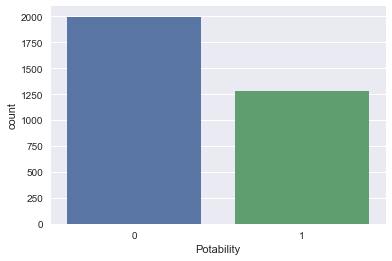

In [6]:
display(water_data['Potability'].value_counts(normalize=True))
sns.countplot(data=water_data, x='Potability');

Итак, `около 61 %` образцов воды являются непригодными для питья и `39 % являются пригодными`. На самом деле это небольшой дисбаланс классов (`61/39`). В реальных задачах мы можете столкнуться и с куда более неравномерными соотношениями, например `80/20`, `90/10` или даже `99/1`. Как работать с такими данными, обсудим далее.

## СТРАТИФИЦИРОВАННОЕ РАЗБИЕНИЕ

>Для того чтобы снизить влияние дисбаланса классов при разбиении выборки, в наборе данных используется специальный тип разбиения, который называется **стратифицированным** (`stratified`). Данное разбиение предполагает, что наблюдения, принадлежащие каждому из классов, гарантированно попадут в каждый из наборов данных в одинаковой пропорции.

Давайте на на примере рассмотрим, как производить стратифицированное разбиение. Начнём с простого разделения `hold-out`, которое мы проводим с помощью функции `train_test_split()`. Для начала проведём обычное случайное разбиение на тренировочную и валидационную выборку (в соотношении `80/20`) без стратификации:

In [7]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.620229
1    0.379771
Name: Potability, dtype: float64
Valid:
0    0.568598
1    0.431402
Name: Potability, dtype: float64


Мы видим, что соотношения классов в тренировочной выборке — `62/38`, а в тестовой — `57/43`. Давайте попробуем сбалансировать соотношения.

Для стратифицированного разбиения достаточно в функции `train_test_split()` задать параметр `stratify`, в который нужно передать столбец с метками классов, на основе которого будет производиться балансировка. Это будет столбец с правильными ответами `y`.

In [8]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.609924
1    0.390076
Name: Potability, dtype: float64
Valid:
0    0.609756
1    0.390244
Name: Potability, dtype: float64


Теперь в каждом из наборов данных одинаковые соотношения классов — `61/39`. Метрики, полученные при одинаковых соотношениях на выборках, будут более объективными.

А что насчёт кросс-валидации? Как организовать разбиение по методу `k-fold` и получить одинаковые соотношения классов?

Для этого вместо `KFold` используется кросс-валидатор `StratifiedKFold`. Принцип работы с ним аналогичен, только, в отличие от `KFold`, `StratifiedKFold` будет разбивать выборку на части таким образом, чтобы в тренировочных и валидационных фолдах соотношения классов были приблизительно одинаковыми.

Давайте напишем код, который организует стратифицированное `k-fold`-разбиение на три фолда, и выведем соотношения классов в каждой из выборок:

In [9]:
skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, valid_index in skf.split(X, y): 
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    print('Train:\n', y_train.value_counts(normalize=True), sep='')
    print('Valid:\n', y_valid.value_counts(normalize=True), sep='')
    print('-'*40)

Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------


Видно, что соотношения классов в тренировочной и валидационной выборках в каждом разбиении примерно одинаковы — `61/39.`

Так же, как и другие кросс-валидаторы, объект класса `StratifiedKFold` может быть использован в функции `cross_validate()`.

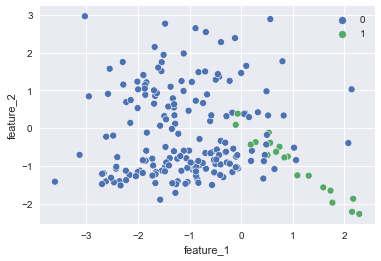

In [10]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y);

Разбейте исходный набор данных на тренировочный и валидационный со стратификацией по классам в соотношении `80/20`. В качестве значения параметра `random_state` возьмите число `42`.

Постройте диаграммы рассеяния с цветовой группировкой по классам для валидационной выборки.

Из приведённых ниже диаграмм выберите ту, которая соответствует полученному разбиению:

Train:
0    0.9
1    0.1
dtype: float64
Valid:
0    0.9
1    0.1
dtype: float64


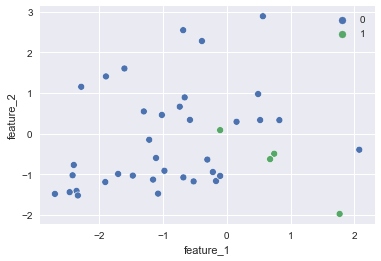

In [13]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')
sns.scatterplot(x=X_valid['feature_1'], y=X_valid['feature_2'], hue=y);

# ВЫБОР МЕТРИК В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ

Мы поговорили о том, как производить разбиение в условиях дисбаланса классов. Следующий пункт в нашем списке проблем — это использование метрик, которые плохо работают с дисбалансом.

Основной представитель таких метрик — это знакомая нам `accuracy`, доля угаданных моделью ответов. Вспомним её формулу:

<img src=ml5_img8.png>

>Загвоздка заключается в том, что данная метрика абсолютно не отражает предсказательную способность модели в отношении каждого из классов. В условиях дисбаланса классов данная метрика может дать ложные представления о качестве модели.

Поэтому используются метрики, которые концентрируются на каждом из классов отдельно, — это знакомые нам из модуля по классификации `precision`, `recall` и `F1-score`.

Давайте на примере посмотрим, насколько важен выбор метрики в случае дисбаланса выборки.

Разобьём выборку на тренировочную и валидационную в соотношении `80/20`, используя стратифицированное разбиение, затем обучим модель дерева решений, сделаем предсказание для каждой из выборок и сформируем отчёт о метриках на валидационной выборке с помощью функции `classification_report()`.

In [15]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       400
           1       0.81      0.55      0.65       256

    accuracy                           0.77       656
   macro avg       0.78      0.73      0.74       656
weighted avg       0.78      0.77      0.76       656



Из отчёта о метриках классификации видно, что для валидационной выборки метрика `accuracy` составляет `0.77`, что, в принципе, является довольно хорошим результатом. Однако если мы посмотрим на метрики `recall` и `f1-score` для каждого из классов в отдельности, мы увидим, что метрики для класса `0` значительно выше, чем метрики для класса `1`.

* Precision для класса `1` составляет `0.81`, то есть из всех образцов воды, причисленных моделью к классу пригодных для питья, `81 %` действительно являются таковыми.

* Recall для класса `1` составляет `0.55`, то есть из всех образцов в действительности пригодной для питья воды модель посчитала пригодными лишь `55 %`, а остальные `45 %` посчитала непригодными.

* `F1-мера` — среднее гармоническое между `precision` и `recall` — составила `0.65` для класса `1` и `0.83` — для класса `0`. Разница довольно **далека от нуля**, а значит построенная нами модель больше контролируется на образцах воды, непригодных для питья, и обладает плохой различающей способностью.

Однако мы не смогли бы выявить этот факт, если бы ориентировались только на метрику `accuracy`. Одной из причин такого результата является дисбаланс классов: образцов непригодной для питья попросту больше, чем пригодных для питья.

>**Примечание**. Поскольку простая accuracy вызывает сомнения в задачах с сильным дисбалансом, были разработаны специальные метрики, основанные на accuracy: это функционал Каппа Коэна (`Cohen’s Kappa`) и `balanced accuracy`. Подробнее о них вы можете прочитать [здесь](https://dyakonov.org/2019/05/31/функционалы-качества-в-задаче-бинарн/).

4. # Недообучение и переобучение. Утечка данных <a class="anchor" id=4></a>

[к содержанию](#0)

5. # Валидация данных. Методы валидации <a class="anchor" id=5></a>

[к содержанию](#0)

6. # Практика <a class="anchor" id=6></a>

[к содержанию](#0)

7. # Итоги <a class="anchor" id=7></a>

[к содержанию](#0)